In [1]:
import numpy as np
import scipy
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import folium
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from camion.fca import E2SFCA
from camion.optimization import RegularOptimizer, MaxiMinOptimizer

In [2]:
sns.set_theme(style="whitegrid", font_scale=1.3)

# Load data

## Population locations

- Download the [polygon file](https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/894e9162-871c-4552-a09c-c6915d8783fb?view_id=2c40fce3-0bb2-46d3-bb67-04a935151a96).

In [3]:
pop_locations = gpd.read_file("data/zip_code_040114.geojson")
pop_locations = pop_locations.drop_duplicates(subset="ZIPCODE")
pop_locations["POPULATION_DENSITY"] = pop_locations["POPULATION"] / pop_locations["AREA"]
pop_locations["geometry_centroid"] = pop_locations["geometry"].apply(lambda r: r.centroid)
pop_locations["Longitude"] = pop_locations["geometry_centroid"].apply(lambda r: r.x)
pop_locations["Latitude"] = pop_locations["geometry_centroid"].apply(lambda r: r.y)
pop_locations["join"] = 1

pop_locations.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,POPULATION_DENSITY,geometry_centroid,Longitude,Latitude,join
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",0.000823,POINT (-73.79650 40.67587),-73.796503,40.675872,1
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679...",0.002107,POINT (-73.93633 40.67116),-73.936327,40.671156,1
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668...",0.001998,POINT (-73.91308 40.66281),-73.913077,40.662813,1
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670...",0.002385,POINT (-73.95396 40.66311),-73.953960,40.663115,1
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650...",0.001960,POINT (-73.97645 40.64332),-73.976451,40.643320,1


## Facilities

### Hospitals in NYC

- [Health Facility General Information](https://health.data.ny.gov/Health/Health-Facility-General-Information/vn5v-hh5r)
- [Health Facility Certification Information](https://health.data.ny.gov/Health/Health-Facility-Certification-Information/2g9y-7kqm)

#### Read facilities general information

In [5]:
facilities = pd.read_csv("data/Health_Facility_General_Information.csv")

In [6]:
facilities = facilities.loc[facilities["Facility Zip Code"].isin(pop_locations["ZIPCODE"])]

facilities.drop_duplicates(subset=["Facility ID"], inplace=True)

facilities["Facility Full Address"] = facilities["Facility Address 1"] + " " \
                                    + facilities["Facility City"] + " " \
                                    + facilities["Facility Zip Code"] + " " \
                                    + facilities["Facility State"].tolist()

facilities = facilities[["Facility ID", "Facility Name", "Facility Latitude",
                         "Facility Longitude", "Facility Full Address"]]

facilities.head()

,Facility ID,Facility Name,Facility Latitude,Facility Longitude,Facility Full Address
3,3138,Bedford Medical Family Health Center Inc,40.704281,-73.962517,100 Ross Street Brooklyn 11211 New York
5,4887,Bronx Gardens Rehabilitation and Nursing Center,40.852428,-73.890343,2175 Quarry Rd Bronx 10457 New York
6,6110,Sheepshead Bay Renal Care Center,40.581875,-73.956436,26 Brighton 11th Street Brooklyn 11235 New York
7,6656,"Physicare Multi-Services, Ltd",40.617695,-73.940674,3508 Flatlands Avenue Brooklyn 11234 New York
8,6802,A Merryland Health Center,NaN,NaN,2873 West 17th Street Brooklyn 11224 New York


#### Add missing lat / long coordinates

In [7]:
facilities_missing_coordinates = pd.read_csv(
    "data/Health_Facility_General_Information_with_all_lat_long.csv",
    index_col=0
)

In [8]:
facilities.loc[facilities.index.isin(facilities_missing_coordinates.index), "Facility Latitude"] = facilities_missing_coordinates["Facility Latitude"]
facilities.loc[facilities.index.isin(facilities_missing_coordinates.index), "Facility Longitude"] = facilities_missing_coordinates["Facility Longitude"]

In [9]:
# Quality check
assert facilities.loc[
    (facilities["Facility Latitude"].isna()) |
    (facilities["Facility Longitude"].isna())
].shape[0] == 0

#### Read facility capacities

In [10]:
facilities_capacity = pd.read_csv("data/Health_Facility_Certification_Information.csv")

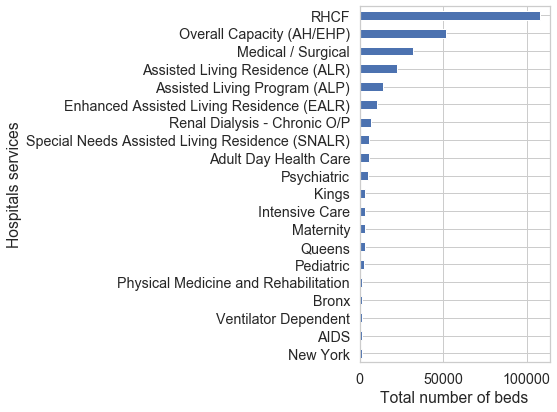

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Subplot 1
ax = facilities_capacity.groupby("Attribute Value")["Measure Value"]\
        .sum()\
        .sort_values()\
        .tail(20)\
        .plot(kind="barh",
              ax=axs)

ax.set_xlabel("Total number of beds")
ax.set_ylabel("Hospitals services")

plt.tight_layout()
plt.show()

In [12]:
facilities_capacity = facilities_capacity.loc[
    (facilities_capacity["Attribute Type"] == "Bed") &
    (facilities_capacity["Attribute Value"] == "Medical / Surgical")
]

facilities_capacity = facilities_capacity[["Facility ID", "Attribute Type", "Attribute Value", "Measure Value"]]

facilities_capacity.head()

,Facility ID,Attribute Type,Attribute Value,Measure Value
5,1,Bed,Medical / Surgical,431.0
59,2,Bed,Medical / Surgical,18.0
70,4,Bed,Medical / Surgical,144.0
95,5,Bed,Medical / Surgical,343.0
325,39,Bed,Medical / Surgical,34.0


In [13]:
facilities_with_capacities = facilities.merge(facilities_capacity, on="Facility ID")
facilities_with_capacities["join"] = 1

facilities_with_capacities.head()

,Facility ID,Facility Name,Facility Latitude,Facility Longitude,Facility Full Address,Attribute Type,Attribute Value,Measure Value,join
0,1639,Mount Sinai Hospital - Mount Sinai Hospital of...,40.768269,-73.924461,25-10 30th Avenue Long Island City 11102 New York,Bed,Medical / Surgical,220.0,1
1,1465,Rockefeller University Hospital,40.762962,-73.956512,1230 York Avenue New York 10021 New York,Bed,Medical / Surgical,40.0,1
2,1178,BronxCare Hospital Center,40.843609,-73.911545,1650 Grand Concourse Bronx 10457 New York,Bed,Medical / Surgical,250.0,1
3,1469,Mount Sinai Morningside,40.805912,-73.961639,1111 Amsterdam Avenue New York 10025 New York,Bed,Medical / Surgical,294.0,1
4,1324,Mount Sinai Brooklyn,40.617954,-73.943230,3201 Kings Highway Brooklyn 11234 New York,Bed,Medical / Surgical,194.0,1


In [14]:
assert facilities_with_capacities["Facility Latitude"].isna().sum() == 0
assert facilities_with_capacities["Facility Longitude"].isna().sum() == 0

## Distance matrix

In [15]:
distance_matrix = pd.merge(
    pop_locations[["ZIPCODE", "Latitude", "Longitude", "join"]],
    facilities_with_capacities[["Facility ID", "Facility Latitude", "Facility Longitude", "join"]],
    on="join"
)

print("{0:,.0f} distance pairs to compute".format(distance_matrix.shape[0]))

distance_matrix.head()

13,640 distance pairs to compute


,ZIPCODE,Latitude,Longitude,join,Facility ID,Facility Latitude,Facility Longitude
0,11436,40.675872,-73.796503,1,1639,40.768269,-73.924461
1,11436,40.675872,-73.796503,1,1465,40.762962,-73.956512
2,11436,40.675872,-73.796503,1,1178,40.843609,-73.911545
3,11436,40.675872,-73.796503,1,1469,40.805912,-73.961639
4,11436,40.675872,-73.796503,1,1324,40.617954,-73.943230


In [16]:
%%time

# Compute geodesic (straight) distance
distance_matrix["geodesic_distance"] = distance_matrix.apply(lambda r: geodesic([r["Latitude"], r["Longitude"]],
                                                                                [r["Facility Latitude"], r["Facility Longitude"]]).km,
                                                             axis=1)

CPU times: user 2.74 s, sys: 22.3 ms, total: 2.76 s
Wall time: 2.81 s


In [17]:
distance_matrix.head()

,ZIPCODE,Latitude,Longitude,join,Facility ID,Facility Latitude,Facility Longitude,geodesic_distance
0,11436,40.675872,-73.796503,1,1639,40.768269,-73.924461,14.904830
1,11436,40.675872,-73.796503,1,1465,40.762962,-73.956512,16.622407
2,11436,40.675872,-73.796503,1,1178,40.843609,-73.911545,21.007916
3,11436,40.675872,-73.796503,1,1469,40.805912,-73.961639,20.076949
4,11436,40.675872,-73.796503,1,1324,40.617954,-73.943230,13.978107


In [18]:
assert distance_matrix["geodesic_distance"].isna().sum() == 0

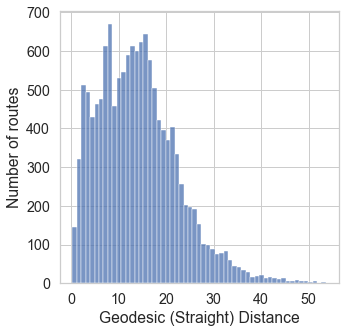

In [19]:
fig = plt.figure(figsize=(5, 5))

ax = sns.histplot(
    distance_matrix,
    x="geodesic_distance"
)

ax.set_xlabel("Geodesic (Straight) Distance")
ax.set_ylabel("Number of routes")

plt.show()

# Accessibility computation

## Convert dataframes to matrices

In [20]:
distance_matrix_pivot = distance_matrix.pivot_table(
    index="ZIPCODE",
    columns="Facility ID",
    values="geodesic_distance"
)

# reorder rows & columns
distance_matrix_pivot = distance_matrix_pivot.reindex(pop_locations["ZIPCODE"])
distance_matrix_pivot = distance_matrix_pivot[facilities_with_capacities["Facility ID"]]

assert all(distance_matrix_pivot.index == pop_locations["ZIPCODE"])
assert all(distance_matrix_pivot.columns == facilities_with_capacities["Facility ID"])

In [21]:
D_ij = distance_matrix_pivot.values
P_i = pop_locations["POPULATION"].values.reshape(1, -1)
S_j = facilities_with_capacities["Measure Value"].values.reshape(1, -1)

## Floating catchment area

In [22]:
weights = [(15, 1), (30, 0.42), (45, 0.09)]

In [23]:
e2sfca = E2SFCA(S_j, P_i, D_ij)
W_ij = e2sfca.compute_weighted_distances(weights)
A_i = e2sfca.compute_accessibility_score(weights)

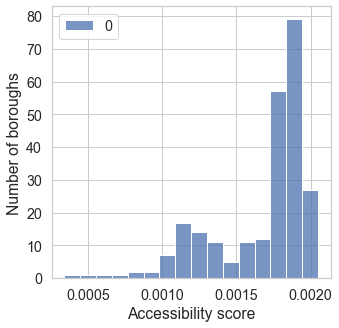

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

ax = sns.histplot(A_i)
ax.set_xlabel("Accessibility score")
ax.set_ylabel("Number of boroughs")

plt.show()

In [25]:
# Save accessibility
pop_locations["A_i"] = A_i

# Accessibility Optimization

In [26]:
budget = 1000
growth_percentage = 0.3

## Regular Optimization

In [27]:
regular_optimizer = RegularOptimizer()

In [28]:
# Run optimization
S_j_new_regular = regular_optimizer.run_optimization(S_j, P_i, W_ij, budget, growth_percentage)

In [29]:
# Compute new accessibility
e2sfca_optim_regular = E2SFCA(S_j_new_regular, P_i, D_ij)
A_i_new_regular = e2sfca_optim_regular.compute_accessibility_score(weights)

## Maxi-min optimization

In [30]:
maximin_optimizer = MaxiMinOptimizer()

In [31]:
# Run optimization
S_j_new_maximin = maximin_optimizer.run_optimization(S_j, P_i, W_ij, budget, growth_percentage)

In [32]:
# Compute new accessibility
e2sfca_optim_maximin = E2SFCA(S_j_new_maximin, P_i, D_ij)
A_i_new_maximin = e2sfca_optim_maximin.compute_accessibility_score(weights)

## Save results

In [33]:
# Regular optimization
pop_locations["A_i_new_regular"] = A_i_new_regular
pop_locations["A_i_delta_regular"] = pop_locations["A_i_new_regular"] - pop_locations["A_i"]

# Maximin optimization
pop_locations["A_i_new_maximin"] = A_i_new_maximin
pop_locations["A_i_delta_maximin"] = pop_locations["A_i_new_maximin"] - pop_locations["A_i"]

In [34]:
# Regular optimization
facilities_with_capacities["capacity_new_regular"] = S_j_new_regular
facilities_with_capacities["capacity_delta_regular"] = facilities_with_capacities["capacity_new_regular"] - facilities_with_capacities["Measure Value"]

# Maximin optimization
facilities_with_capacities["capacity_new_maximin"] = S_j_new_maximin
facilities_with_capacities["capacity_delta_maximin"] = facilities_with_capacities["capacity_new_maximin"] - facilities_with_capacities["Measure Value"]

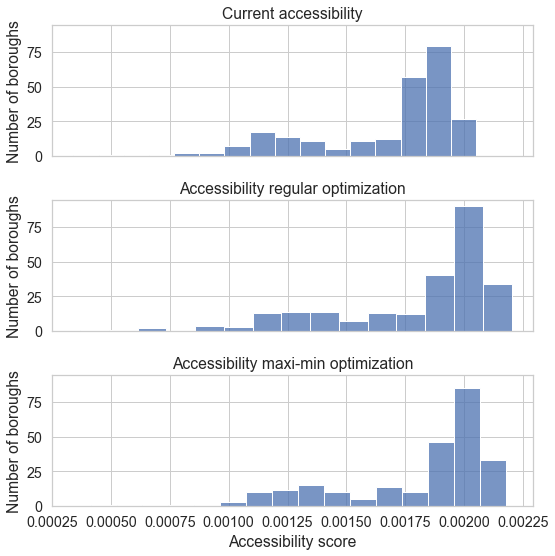

In [35]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex=True, sharey=True)

# Subplot 1
sns.histplot(
    data=pop_locations,
    x="A_i",
    ax=axs[0]
)

axs[0].set_title("Current accessibility")
axs[0].set_xlabel("Accessibility score")
axs[0].set_ylabel("Number of boroughs")

# Subplot 2
sns.histplot(
    data=pop_locations,
    x="A_i_new_regular",
    ax=axs[1]
)

axs[1].set_title("Accessibility regular optimization")
axs[1].set_xlabel("Accessibility score")
axs[1].set_ylabel("Number of boroughs")

# Subplot 3
sns.histplot(
    data=pop_locations,
    x="A_i_new_maximin",
    ax=axs[2]
)

axs[2].set_title("Accessibility maxi-min optimization")
axs[2].set_xlabel("Accessibility score")
axs[2].set_ylabel("Number of boroughs")

plt.tight_layout()
plt.show()

# Interactive map

In [36]:
interactive_map = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=12,
    tiles="cartodbpositron"
)

# Add population
folium.Choropleth(
    name="Population density",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "POPULATION_DENSITY"],
    key_on="feature.id",
    fill_color="YlGnBu",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility, before optimization
folium.Choropleth(
    name="Accessibility score, before optimization",
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i"],
    key_on="feature.id",
    fill_color="YlGn",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add facilities
for _, row in facilities_with_capacities.iterrows():   
    folium.Marker(
        name="Facilities",
        show=True,
        location=(row["Facility Latitude"], row["Facility Longitude"]),
        popup=row["Facility Name"],
        icon=folium.DivIcon(html="""
            <div><svg>
                <rect width="{0}"
                      height="{0}"
                      fill="{1}"
                      opacity=".8"
                      stroke="black"
                      stroke-width=".5"
                />
            </svg></div>
            """.format(row["Measure Value"] / 20, "#fee6ce")
        )
    ).add_to(interactive_map)

# Add accessibility delta, after regular optimization
folium.Choropleth(
    name="Accessibility delta, after regular optimization",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i_delta_regular"],
    key_on="feature.id",
    fill_color="Purples",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility delta, after maxi-min optimization
folium.Choropleth(
    name="Accessibility delta, after maxi-min optimization",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i_delta_maximin"],
    key_on="feature.id",
    fill_color="Purples",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add LayerControl
folium.LayerControl().add_to(interactive_map)
    
# Save map
interactive_map.save("/Users/eric/Desktop/map.html")

/usr/local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


# Export data

In [39]:
facilities_with_capacities.to_csv("results/csv/facilities_with_capacities.csv", index=False)
pop_locations.to_csv("results/csv/pop_locations.csv", index=False)